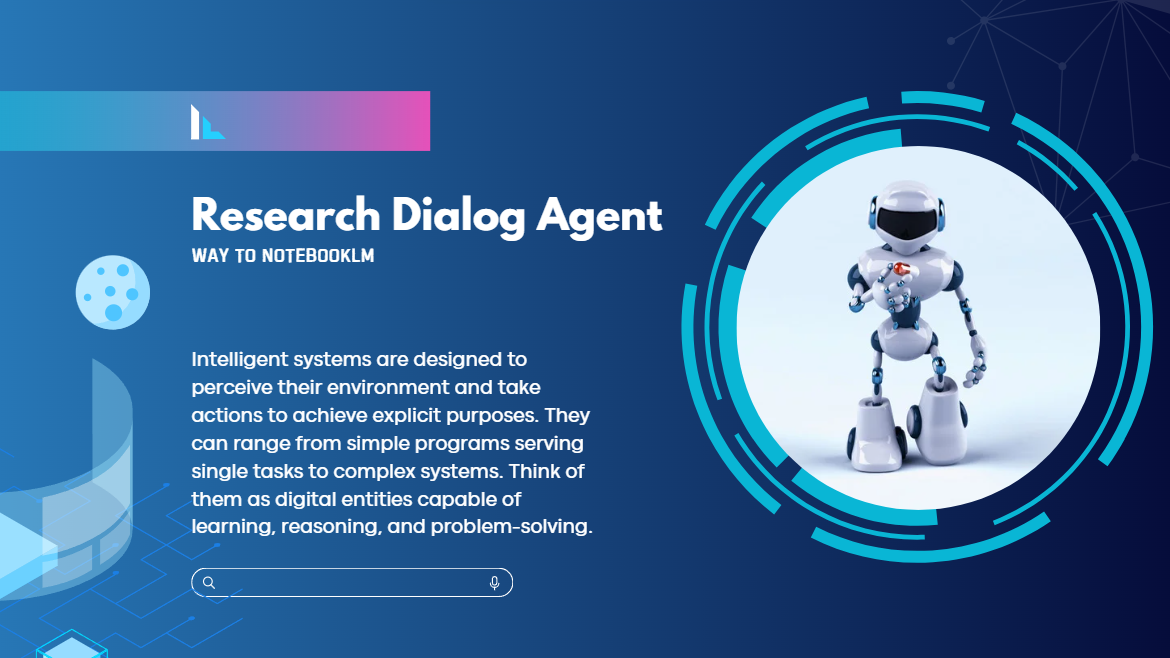

Imagine a massive problem, so large that it would take several days/months for a single person to solve it. Now, picture a team of skilled people, each given a specific section of the task to work on. They might start by sorting the plans by objective or complexity, then gradually piecing together smaller sections. Once each solver has completed their section, they come together to combine their solutions into the final solution.

This is essentially how map-reduce works in Agentic AI. The main "problem" gets divided into sub-problem statements, the "solvers" are individual LLMs, which map each sub-plan with different solvers. Each solver works on its assigned sub-problem, performing calculations or inferring information as needed. Finally, the results from all "solvers" are combined (reduce) to produce the final output.

## Introduction

After advancements in generative AI, LLM agents are quite popular, and people are taking advantage of their capabilities.
Some argue that agents can automate the process end to end. However, I view them as productivity enablers. They can assist in problem-solving, designing workflow, and enabling humans to focus on critical parts. For instance, agents can serve as automated provers exploring the space of mathematical proofs. They can offer new perspectives and ways of thinking beyond "human-generated" proofs.

Another, latest example is AI-enabled Cursor Studio. The cursor is a controlled environment similar to VS code supporting programming assistance.

Agents are also becoming more capable of planning and taking action, resembling the way humans reason, and most importantly, they can adjust their strategies. They are quickly improving in their ability to analyze tasks, develop plans to complete them, and refine their approach through repeated self-critique. There are even techniques that involve keeping humans in the loop, where agents seek guidance from humans at intervals and then proceed based on those instructions.

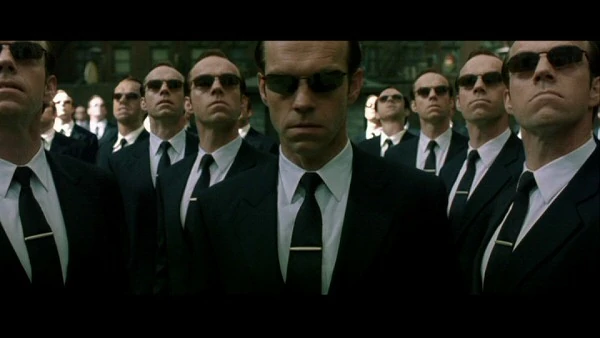

### What I have for you?
Furthermore, with this blog, I would like to show one small agent built-in with `Langgraph` and `Google Gemini` for research purposes. The objective is to demonstrate one research agent that plans to summarize the research paper. This tool will use a vision model to infer the information.  This method only identifies the step and its sub-steps and tries to get the answer for those action items. Finally, all the answers get converted into conversations where two people will be discussing the paper. You can consider this as a mini `NotebookLM` of Google.

To elaborate further, I am using a single uni-directed graph where communication between steps is happening from top to bottom. I have also used conditional node connection to process repeated jobs.

* A process to build simple agents with the help of langgraph
* MultiModal Conversation with Google Gemini llm

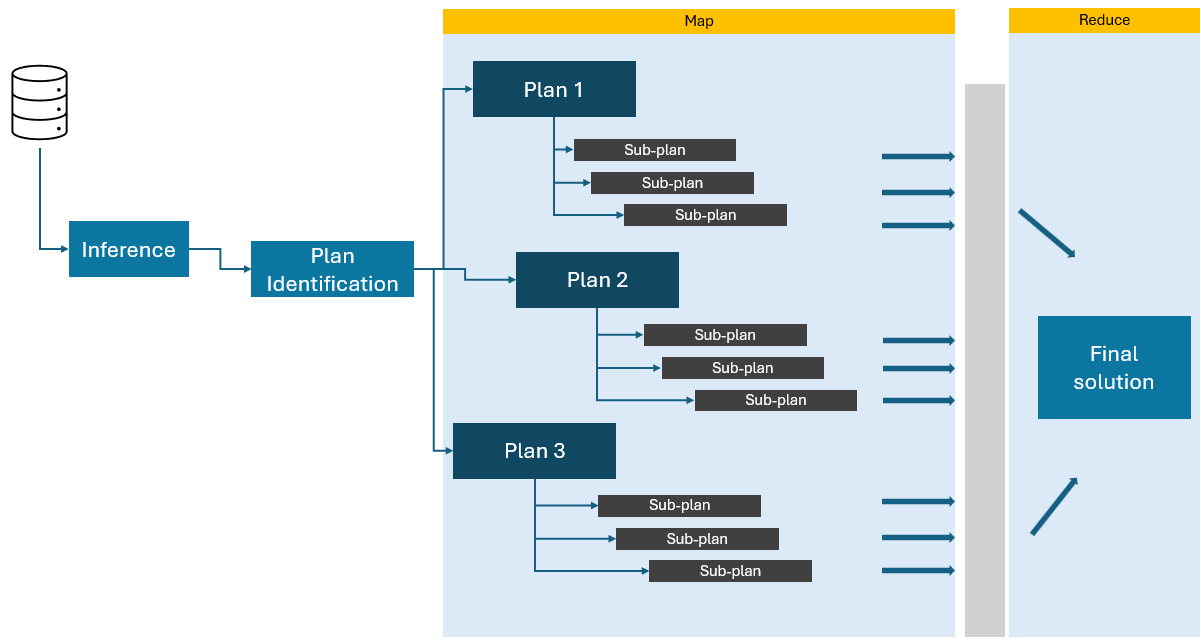

### What is not included?
* I have not included any tools like search or any custom function to make it more advanced.
* No routing approach or reverse connection is developed.
* No branching techniques are used for parallel processing or conditional job
* Can be implemented by loading pdf and parsing images and graphs. 
* Playing with only 3 images in one prompt.

Let's install a few required Python dependencies.

* `langchain-google-genai` : To connect langchain with google generative AI models
* `python-dotenv`: To load secrete keys or any environment variables
* `langgraph`: To construct the agents
* `pypdfium2 & pillow`: To convert pdf into images

In [1]:
# %pip install -qU langchain-google-genai
# %pip install python-dotenv
# %pip install -U langgraph
# %pip install "pypdfium2==4" pillow

Load the supporting libraries

In [1]:
from dotenv import dotenv_values
from langchain_core.messages import HumanMessage
import os
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, START, END,MessagesState
from langgraph.graph.message import add_messages
from langgraph.constants import Send
import pypdfium2 as pdfium
import json
from PIL import Image

import operator
from typing import Annotated, TypedDict # ,Optional, List
from langchain_core.pydantic_v1 import BaseModel # ,Field

Load environment variables

In [2]:
config = dotenv_values("../.env") 
os.environ["GOOGLE_API_KEY"] = config['GEMINI_API']

Currently, I am using a Multimodal approach in this project. To achieve this, I load a PDF file and convert each page into an image. These images are then fed into the Gemini vision model for conversational purposes.

The following code demonstrates how to load a PDF file, convert each page into an image, and save these images to a directory.

In [5]:
pdf = pdfium.PdfDocument("./pdf_image/vision.pdf")

for i in range(len(pdf)):
    page = pdf[i]
    image = page.render(scale=4).to_pil()
    image.save(f"./pdf_image/vision_P{i:03d}.jpg")

Let's display the one page for our reference.

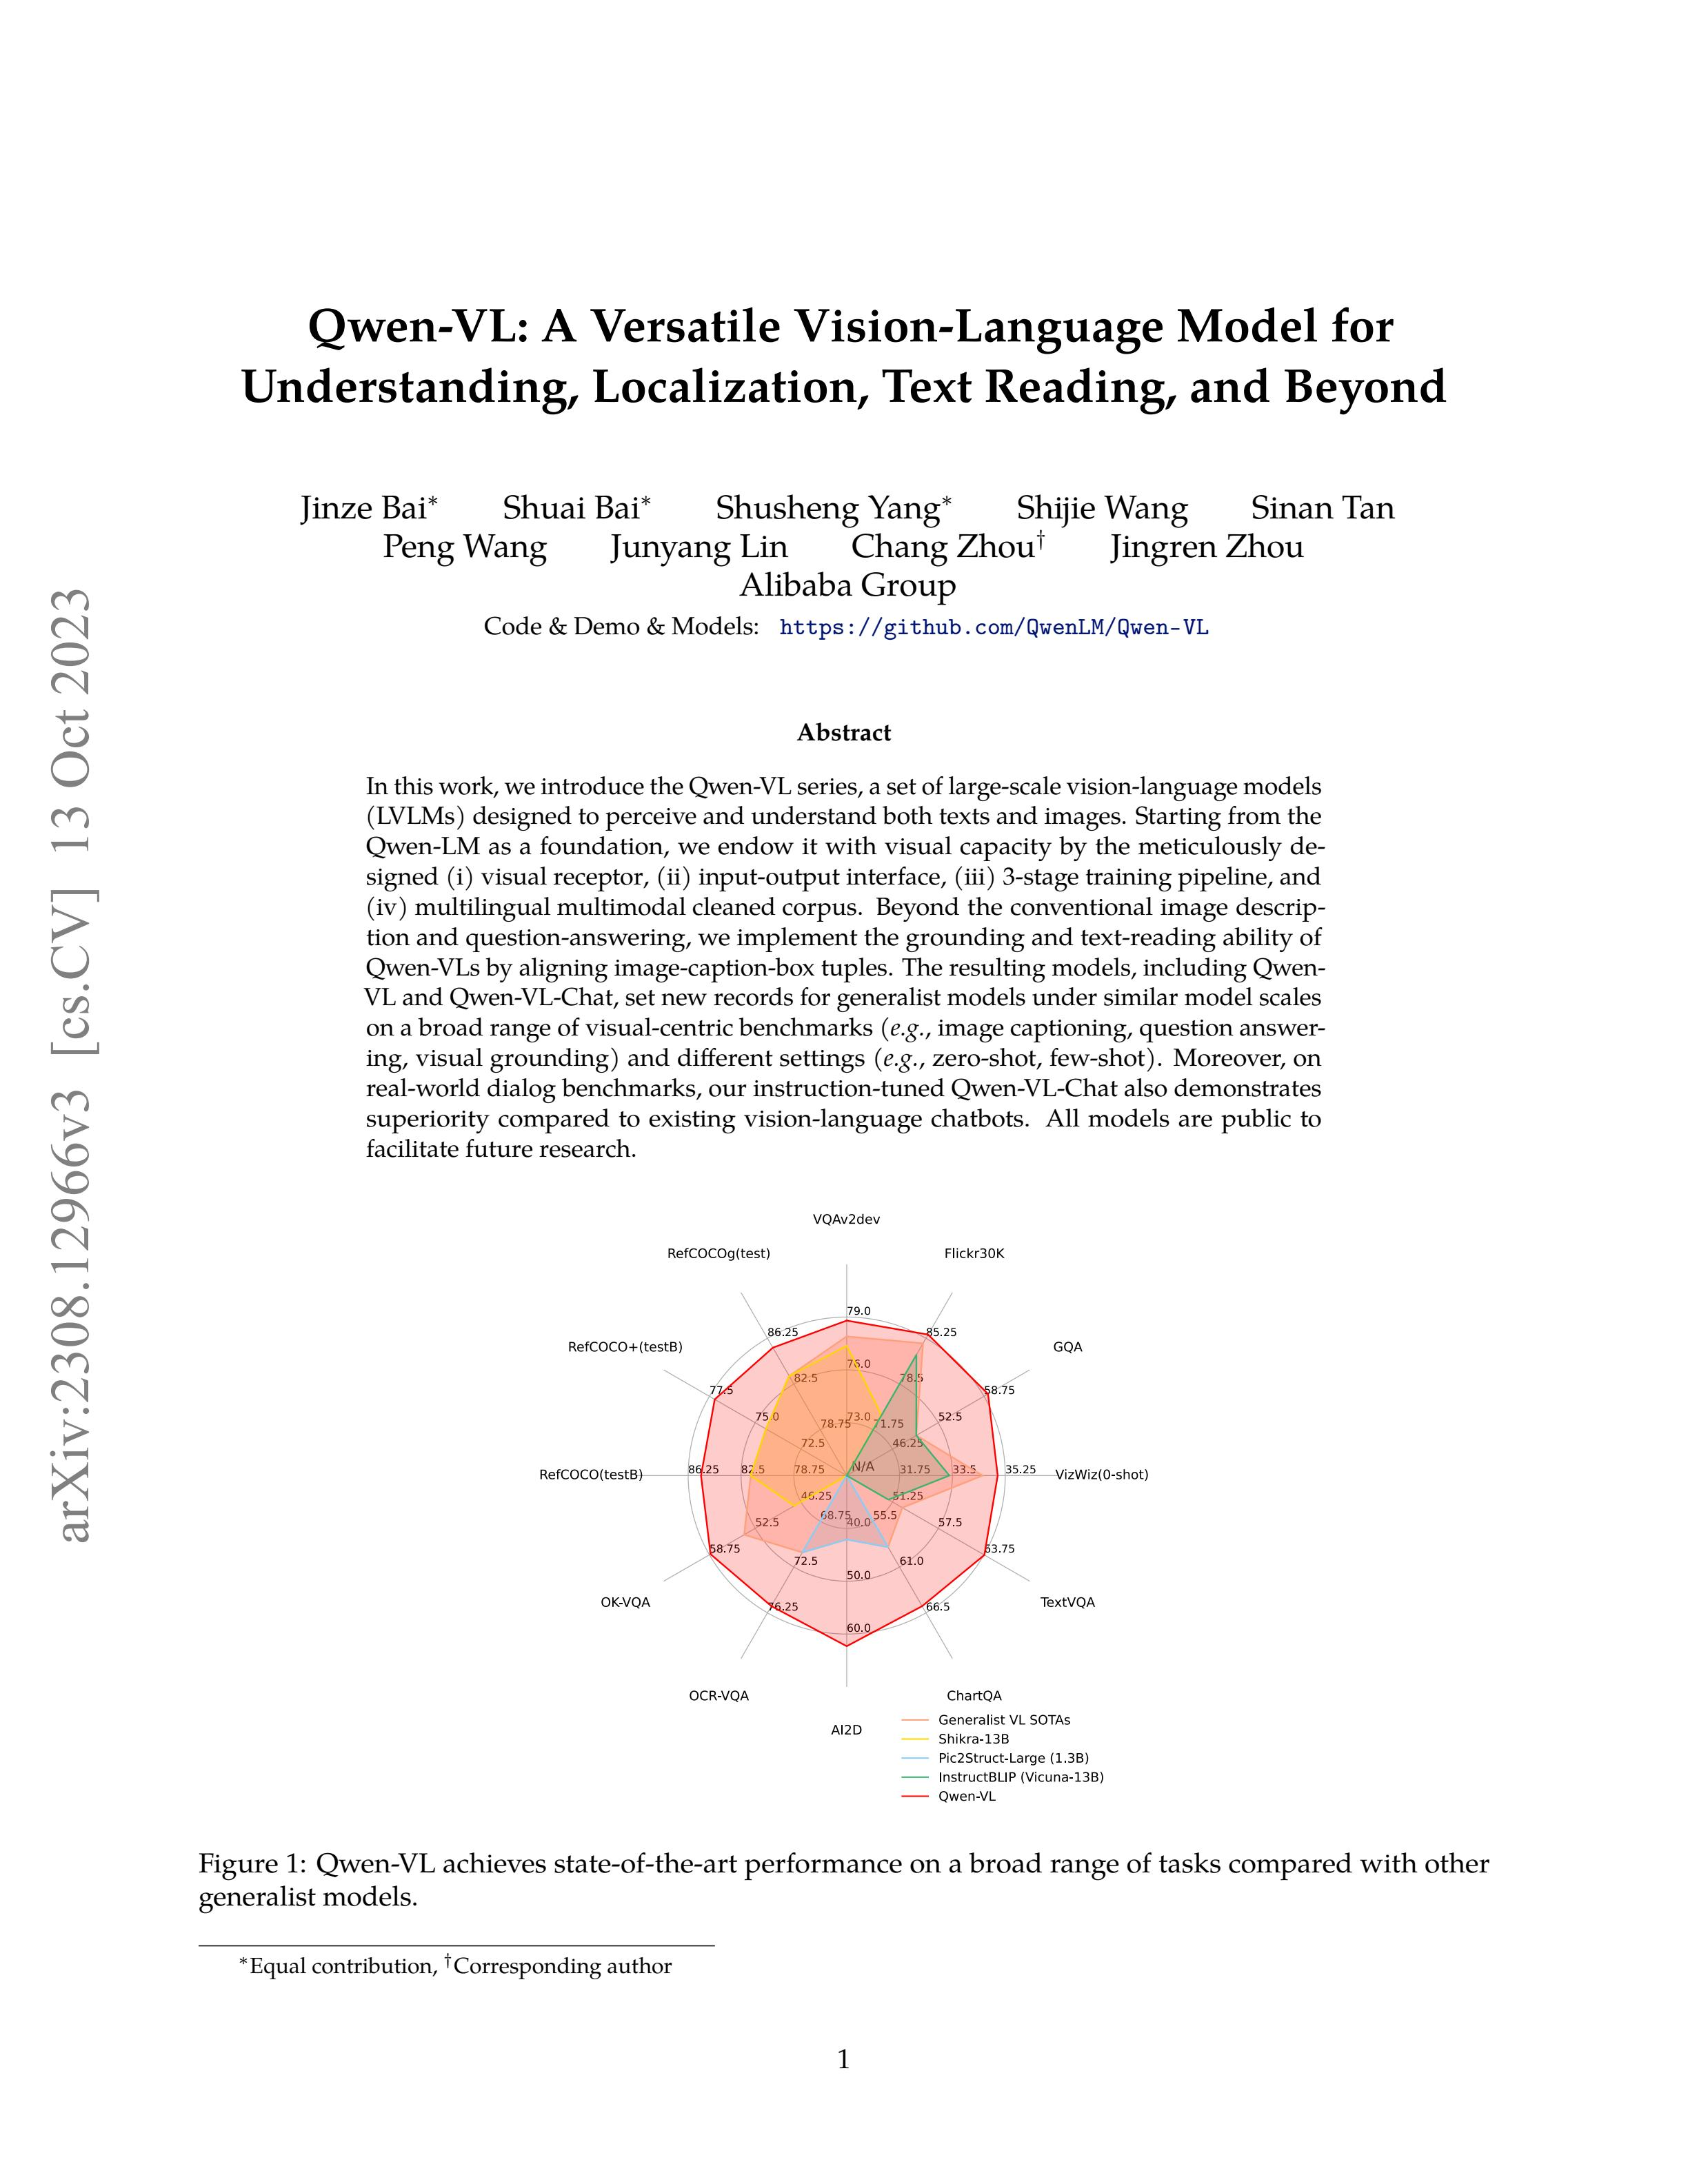

In [7]:
image_path = "./pdf_image/vision_P000.jpg"
img = Image.open(image_path)
img

Connecting Gemini model through API key. Given the following are the different variants available. One important thing to notice is that we should select the model which supports the data type. Since I am working with images in the conversation, I needed to opt for either the Gemini 1.5 Pro or Flash models, as these variants support image data.

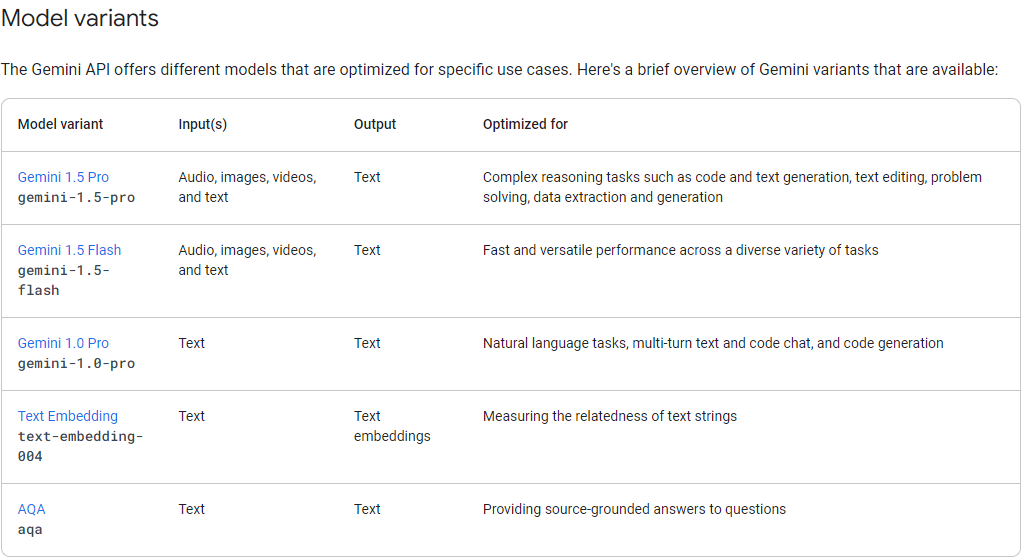

In [8]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-001", # "gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

Let’s move forward by building the schema to manage the output and transfer information between nodes. Utilize the add operator to merge all the steps and sub-steps that the agent will create.

In [9]:
class State(TypedDict):
    image_path: str # To store reference of all the pages
    steps:  Annotated[list, operator.add] # Store all the steps generated by the agent

    substeps: Annotated[list, operator.add] # Store all the sub steps generated by the agent for every step
    solutions:  Annotated[list, operator.add] # Store all the solutions generated by the agent for each step
    content:str # store the content of the paper
    plan:str # store the processed plan
    Dialog:  Annotated[list, operator.add]
    
    

Schema to control the output of the first step.

In [10]:
class Task(BaseModel):
    task: str

Schema to store the output of each sub-step based on identified tasks in the previous step.

In [11]:
class SubStep(BaseModel):
    substep: str

Schema to control the output during conditional looping.

In [12]:
class StepState(TypedDict):
    step: str
    image_path: str
    solutions: str
    Dialog:  str

## Step 1: Generate Tasks
In our first step, we'll pass the images to the LLM and instruct it to identify all the plans it intends to execute to fully understand the research paper. I'll be providing multiple pages at once, asking the model to generate a combined plan based on all the images.

In [13]:
def generate_steps(state: State):
    prompt="""
    Consider you are a research scientist in artificial intelligence who is expert in understanding research papers. 
    You will be given a research paper and you need to identify all the steps a researcher need to perform. 
    Identify each steps and their substeps.
    """
    message = HumanMessage(content=[{'type':'text','text':prompt},
                                    *[{"type":'image_url','image_url':img} for img in state['image_path']]
                                    ]
                                    
                                    )
    response = llm.invoke([message])
    return {"content": [response.content],"image_path":state['image_path']}

## Step 2 : Plan Parsing
In this step, we will take the plan identified in the first step and instruct the model to convert it into a structured format. I have defined the schema and included that information with the prompt. It's important to note that external parsing tools can be used to transform the plan into a proper data structure. To enhance robustness, you could use "Tools" to parse the data or create a more rigorous schema as well.


In [14]:
def markdown_to_json(state: State):
    prompt =""" 
    You are given a markdown content and you need to parse this data into json format. Follow correctly key and value
    pairs for each bullet point.
    Follow following schema strictly.
    
    schema: 
    [
    {
      "step": "description of step 1 ",
      "substeps": [
        {
          "key": "title of sub step 1 of step 1",
          "value": "description of sub step 1 of step 1"
        },
        {
          "key": "title of sub step 2 of step 1",
          "value": "description of sub step 2 of step 1"
        }]},
        {
      "step": "description of step 2",
      "substeps": [
        {
          "key": "title of sub step 1 of step 2",
          "value": "description of sub step 1 of step 2"
        },
        {
          "key": "title of sub step 2 of step 2",
          "value": "description of sub step 2 of step 2"
        }]}]'
    
    Content:
    %s
    """% state['content']
    str_response = llm.invoke([prompt])
    return({'content':str_response.content,"image_path":state['image_path']})

## Step 3 Text To Json
In the 3rd step, we will take the plan identified in 2nd step and convert it into JSON format. Please note that this method may not always work if LLM violates the schema structure.

In [15]:
def parse_json(state: State):
    str_response_json = json.loads(state['content'][7:-3].strip())
    output = []
    for step in str_response_json:
        substeps = []
        for item in step['substeps']:
            for k,v in item.items():
                if k=='value':
                    substeps.append(v)
        output.append({'step':step['step'],'substeps':substeps})
    return({"plan":output})

## Step 4 Solution For each Step
The solution findings of every step will be taken care of by this step. It will take one plan and combine all the sub-plans in a pair of Questions and Answers in a single prompt. Furthermore, LLM will identify the solution of every sub-step. 
This step will also combine the multiple outputs into one with the help of the Annotator and "add" operator.

For now, this step is working with fair quality. However, it can be improved by using branching and translating every sub-step into a proper reasoning prompt. Mainly, every substep should get translated into a chain of thought so that LLM can prepare a solution. One can use React as well.


In [16]:
def sovle_substeps(state: StepState):
    print(state)
    inp = state['step']
    print('solving sub steps')
    qanda = ' '.join([f'\n Question: {substep} \n Answer:' for substep  in inp['substeps']])
    prompt=f""" You will be given instruction to analyze research papers. You need to understand the 
    instruction and solve all the questions mentioned in the list. 
    Keep the pair of Question and its answer in your response. Your response should be next to the keyword "Answer"
    
    Instruction:
    {inp['step']}
    Questions:
    {qanda}
    """
    message = HumanMessage(content=[{'type':'text','text':prompt},
                                    *[{"type":'image_url','image_url':img} for img in state['image_path']]
                                    ]
                                    )
    response = llm.invoke([message])
    return {"steps":[inp['step']], 'solutions':[response.content]}

## Step 5 Conditional loop
This step is critical for managing the flow of the conversation. It involves an iterative process that maps out the generated plans (steps) and continuously passes information from one node to another in a loop. The loop terminates once all the plans have been executed. Currently, this step handles one-way communication between nodes, but if there's a need for bi-directional communication, we would need to consider implementing different branching techniques.


In [17]:
def continue_to_substeps(state: State):
    steps = state['plan']
    return [Send("sovle_substeps", {"step": s,'image_path':state['image_path']}) for s in steps]

## Step 6 Voice

After all the answers are generated, the following code will turn them into a dialogue, and then combine everything into a podcast featuring two people discussing the paper. The following prompt is taken from https://github.com/gabrielchua/open-notebooklm/blob/main/prompts.py

In [18]:
SYSTEM_PROMPT = """
You are a world-class podcast producer tasked with transforming the provided input text into an engaging and informative podcast script. The input may be unstructured or messy, sourced from PDFs or web pages. Your goal is to extract the most interesting and insightful content for a compelling podcast discussion.

# Steps to Follow:

1. **Analyze the Input:**
   Carefully examine the text, identifying key topics, points, and interesting facts or anecdotes that 
   could drive an engaging podcast conversation. Disregard irrelevant information or formatting issues.

2. **Brainstorm Ideas:**
   In the `<scratchpad>`, creatively brainstorm ways to present the key points engagingly. Consider:
   - Analogies, storytelling techniques, or hypothetical scenarios to make content relatable
   - Ways to make complex topics accessible to a general audience
   - Thought-provoking questions to explore during the podcast
   - Creative approaches to fill any gaps in the information

3. **Craft the Dialogue:**
   Develop a natural, conversational flow between the host (Jane) and the guest speaker (the author or an expert on the topic). Incorporate:
   - The best ideas from your brainstorming session
   - Clear explanations of complex topics
   - An engaging and lively tone to captivate listeners
   - A balance of information and entertainment

   Rules for the dialogue:
   - The host (Jane) always initiates the conversation and interviews the guest
   - Include thoughtful questions from the host to guide the discussion
   - Incorporate natural speech patterns, including occasional verbal fillers (e.g., "um," "well," "you know")
   - Allow for natural interruptions and back-and-forth between host and guest
   - Ensure the guest's responses are substantiated by the input text, avoiding unsupported claims
   - Maintain a PG-rated conversation appropriate for all audiences
   - Avoid any marketing or self-promotional content from the guest
   - The host concludes the conversation

4. **Summarize Key Insights:**
   Naturally weave a summary of key points into the closing part of the dialogue. This should feel like a casual conversation rather than a formal recap, reinforcing the main takeaways before signing off.

5. **Maintain Authenticity:**
   Throughout the script, strive for authenticity in the conversation. Include:
   - Moments of genuine curiosity or surprise from the host
   - Instances where the guest might briefly struggle to articulate a complex idea
   - Light-hearted moments or humor when appropriate
   - Brief personal anecdotes or examples that relate to the topic (within the bounds of the input text)

6. **Consider Pacing and Structure:**
   Ensure the dialogue has a natural ebb and flow:
   - Start with a strong hook to grab the listener's attention
   - Gradually build complexity as the conversation progresses
   - Include brief "breather" moments for listeners to absorb complex information
   - End on a high note, perhaps with a thought-provoking question or a call-to-action for listeners
"""

In [19]:
def generate_dialog(state):
    text = state['text']
    tone = state['tone']
    length = state['length']
    language = state['language']

    modified_system_prompt = SYSTEM_PROMPT
    modified_system_prompt += f"\n\PLEASE paraphrase the following TEXT in dialog format."

    if tone:
        modified_system_prompt += f"\n\nTONE: The tone of the podcast should be {tone}."
    if length:
        length_instructions = {
            "Short (1-2 min)": "Keep the podcast brief, around 1-2 minutes long.",
            "Medium (3-5 min)": "Aim for a moderate length, about 3-5 minutes.",
        }
        modified_system_prompt += f"\n\nLENGTH: {length_instructions[length]}"
    if language:
        modified_system_prompt += (
            f"\n\nOUTPUT LANGUAGE <IMPORTANT>: The the podcast should be {language}."
        )

    messages = modified_system_prompt + '\nTEXT: '+ text

    response = llm.invoke([messages])
    return {"Step":[state['step']],"Finding":[state['text']], 'Dialog':[response.content]}

In [20]:
def continue_to_substeps_voice(state: State):
    print('voice substeps')

    solutions = state['solutions']
    steps = state['steps']

    tone ='Formal' #  ["Fun", "Formal"]
    return [Send("generate_dialog", {"step":st,"text": s,'tone':tone,'length':"Short (1-2 min)",'language':"EN"}) for st,s in zip(steps,solutions)]

## Step 7 Graph Construction
Now it’s time to assemble all the steps we've outlined:

1. **Initialize the Graph**:
    * Start by initializing the graph and defining all the necessary nodes.
2. **Define and Connect Nodes**:
    * Use edges to connect the nodes, ensuring the flow of information from one node to another.
3. **Introduce the Loop**:
    * Implement the loop as described in step 5, allowing for iterative processing of the plans.
4. **Terminate the Process**:
    * Finally, use the END method of langraph to properly close and terminate the process.

In [21]:
graph = StateGraph(State)
graph.add_node("generate_steps", generate_steps)
graph.add_node("markdown_to_json", markdown_to_json)
graph.add_node("parse_json", parse_json)
graph.add_node("sovle_substeps", sovle_substeps)
graph.add_node("generate_dialog", generate_dialog)

graph.add_edge(START, "generate_steps")
graph.add_edge("generate_steps", "markdown_to_json")
graph.add_edge("markdown_to_json", "parse_json")
graph.add_conditional_edges("parse_json", continue_to_substeps, ["sovle_substeps"])
graph.add_conditional_edges("sovle_substeps", continue_to_substeps_voice, ["generate_dialog"])
graph.add_edge("generate_dialog", END)
app = graph.compile()

It's time to display the network for better understanding.

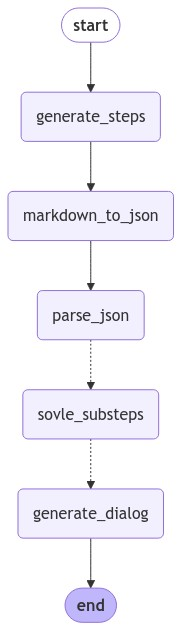

In [22]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print('There seems error')

Let’s begin the process and evaluate how the current framework operates. For now, I am testing with only three images, though this can be extended to multiple images. The code will take images as input and pass this data to the graph's entry point. Subsequently, each step will take the input from the previous step and pass the output to the next step until the process is completed.


In [23]:
output = []
for s in app.stream({"image_path": [f"./pdf_image/vision_P{i:03d}.jpg" for i in range(6)]}):
    output.append(s)

with open('./data/output.json','w') as f:
    json.dump(output,f)

{'step': {'step': 'Introduction', 'substeps': ['Large Language Models (LLMs) have limitations in visual understanding and fine-grained perception. Existing Vision-Language Models (VLMs) are often limited in real-world scenarios.', 'Introduce the new model, "Owen-VL," a versatile vision-language model. Highlight the key features of Owen-VL:\n* State-of-the-art performance on various tasks.\n* Ability to understand and generate text, localize objects, and read text.\n* Multilingual support.', 'Briefly describe the sections that follow.']}, 'image_path': ['./pdf_image/vision_P000.jpg', './pdf_image/vision_P001.jpg', './pdf_image/vision_P002.jpg', './pdf_image/vision_P003.jpg', './pdf_image/vision_P004.jpg', './pdf_image/vision_P005.jpg']}
solving sub steps
{'step': {'step': 'Methodology', 'substeps': ['Explain the three components of Owen-VL:\n* Large Language Model (LLM)\n* Vision Encoder\n* VL Adapter\nProvide details of the model parameters.', "Describe how images are processed through

In [37]:
len(output)

15

In [36]:
output[9]

{'generate_dialog': {'Dialog': ["## Podcast Script: Owen-VL: A New Era of Vision-Language Models\n\n**[INTRO MUSIC]**\n\n**Jane:** Welcome back to the show, everyone! Today, we're diving into the exciting world of artificial intelligence, specifically the realm of vision-language models. And joining me is [Guest Name], an expert in this field. [Guest Name], thanks for being here!\n\n**[Guest Name]:** It's a pleasure to be here, Jane.\n\n**Jane:** So, [Guest Name], I've been reading about this new series of models called Owen-VL. Can you tell us a bit about what makes them so special?\n\n**[Guest Name]:** Absolutely. Owen-VL is a series of large-scale vision-language models, or VLMs for short. They're designed to be incredibly versatile, capable of handling a wide range of tasks that involve both visual and textual information.\n\n**Jane:** That sounds impressive. What kind of tasks are we talking about?\n\n**[Guest Name]:** Well, think about it this way. Owen-VL can understand images, 

In [33]:
with open('./data/output.json','r') as f:
    output1 = json.load(f)

In [34]:
print(output1[10]['generate_dialog']['Dialog'][0])

## Owen-VL: A New Era of Vision-Language Models

**<center>Podcast Script</center>**

**[INTRO MUSIC]**

**Jane:** Welcome back to the show, everyone! Today, we're diving into the exciting world of artificial intelligence, specifically focusing on a new development in vision-language models. Joining me is [Guest Name], a leading researcher in this field. [Guest Name], thanks for being here!

**[Guest Name]:** It's a pleasure to be here, Jane.

**Jane:** So, [Guest Name], we've seen a lot of progress in AI, but it seems like there's still a gap when it comes to machines truly understanding and interacting with the visual world. Can you tell us about this challenge?

**[Guest Name]:** You're right, Jane. While AI has made significant strides in language processing, visual understanding remains a hurdle. Existing vision-language models, or VLMs, often struggle in real-world scenarios. They might be good at recognizing objects, but they lack the depth of understanding needed for complex ta

## Stream
I'm using the following code to stream the results sequentially, where each plan and sub-plan will be mapped to a corresponding response.

In [231]:
import sys
import time
def printify(tx,stream=False):
    if stream:
        for char in tx:
            sys.stdout.write(char)
            sys.stdout.flush()
            time.sleep(0.05)
    else:
        print(tx)

In [232]:
topics =[]
substeps=[]
for idx, plan in enumerate(output1[2]['parse_json']['plan']):
    topics.append(plan['step'])
    substeps.append(plan['substeps'])

Let's separate the answers of every sub-step

In [233]:
text_planner = {}
stream = False

for topic,substep,responses in zip(topics,substeps,output1[3:10]):
    response = responses['sovle_substeps']
    response_topic = response['steps']
    if topic in response_topic:
        answer = response['solutions'][0].strip().split('Answer:')
        answer =[ans.strip() for ans in answer if len(ans.strip())>0]
        for q,a in zip(substep,answer):
            printify(f'Sub-Step : {q}\n',stream=stream)
            printify(f'Action : {a}\n',stream=stream)
        text_planner[topic]={'answer':list(zip(substep,answer))}

Sub-Step : Construct a target detection dataset containing 6000 images of gold and sulfuric iron ore.

Action : A target detection dataset containing 6000 images of gold and sulfuric iron ore can be constructed by collecting images from various sources, such as online databases, mining companies, and research institutions. The images should be labeled with bounding boxes around the gold and sulfuric iron ore objects.

Sub-Step : Set up comparison experiments using other object detection architectures, such as YOLOv5, EMA, APPN.

Action : Comparison experiments can be set up by training and evaluating the performance of YOLOv5, EMA, and APPN on the constructed dataset. The performance can be measured using metrics such as mean average precision (mAP), accuracy, and speed. The results can then be compared to the performance of the proposed method to assess its effectiveness.

Sub-Step : Analyze the experimental results and discuss the model's performance.

Action : The proposed model, Or

All the answers get converted into dialog in the last node in the graph. Let's store them in separate variables so that we can convert them into voice.

In [234]:
stream = False

dialog_planner ={}
for topic,responses in zip(topics,output1[10:17]):
    dialog = responses['generate_dialog']['Dialog'][0]
    dialog = dialog.strip().split('## Podcast Script')[-1].strip()
    dialog = dialog.replace('[Guest Name]','Robin').replace('**Guest:**','**Robin:**')
    printify(f'Dialog: : {dialog}\n',stream=stream)
    dialog_planner[topic]=dialog

Dialog: : : The Future of Ore Sorting

**[INTRO MUSIC]**

**Jane:** Welcome back to "Tech Talk," where we explore the latest advancements in technology. Today, we're diving into the world of mining with a fascinating topic: AI-powered ore sorting. Joining me is Robin, an expert in this field. Robin, thanks for being here.

**Robin:** It's a pleasure to be here, Jane.

**Jane:** So, Robin, let's talk about this new AI-powered ore sorting technology. How does it work, and what makes it so revolutionary?

**Robin:** Well, Jane, traditional ore sorting methods often rely on physical separation techniques, which can be inefficient and sometimes inaccurate. This new AI-powered approach uses computer vision and deep learning algorithms to analyze ore samples in real-time. It can identify different types of ore with incredible precision, allowing for more efficient and accurate sorting.

**Jane:** That's incredible! So, how does this AI-powered system compare to other ore sorting methods?

**R

In [235]:
print(dialog_planner['Data Collection and Preparation'])

: The Future of Ore Sorting

**[INTRO MUSIC]**

**Jane:** Welcome back to "Tech Talk," where we explore the latest advancements in technology. Today, we're diving into the world of mining with a fascinating topic: AI-powered ore sorting. Joining me is Robin, an expert in this field. Robin, thanks for being here.

**Robin:** It's a pleasure to be here, Jane.

**Jane:** So, Robin, let's talk about this new AI-powered ore sorting technology. How does it work, and what makes it so revolutionary?

**Robin:** Well, Jane, traditional ore sorting methods often rely on physical separation techniques, which can be inefficient and sometimes inaccurate. This new AI-powered approach uses computer vision and deep learning algorithms to analyze ore samples in real-time. It can identify different types of ore with incredible precision, allowing for more efficient and accurate sorting.

**Jane:** That's incredible! So, how does this AI-powered system compare to other ore sorting methods?

**Robin:** St

In [225]:
print(dialog_planner['Model Training'])

: Mining for Gold with AI

**[INTRO MUSIC]**

**Jane:** Welcome back to "Tech Talk," where we explore the fascinating world of technology and its impact on our lives. Today, we're diving into the world of mining, but not just any mining – we're talking about using artificial intelligence to find gold! Joining me is Robin, an expert in AI and its applications in the mining industry. Robin, thanks for being here.

**Robin:** It's a pleasure to be here, Jane.

**Jane:** So, tell me, how can AI actually help us find gold?

**Robin:** Well, it's all about image recognition. We can train AI models to identify gold and other valuable minerals in images. Imagine a dataset of thousands of images, each labeled with the location of gold or sulfuric iron ore. 

**Jane:** That sounds like a lot of data!

**Robin:** It is! We can collect these images from various sources, like online databases, mining companies, and research institutions. Once we have this dataset, we can train AI models like YOLOv5

In [236]:
with open('./data/text_planner.json','w') as f:
    json.dump(text_planner,f)

In [237]:
with open('./data/dialog_planner.json','w') as f:
    json.dump(dialog_planner,f)

In [122]:
# !pip install pydub
# !pip install gradio-client

## Dialog to Voice

In [238]:
from pydantic import BaseModel, Field
from typing import List, Literal, Tuple, Optional
import glob
import os
import time
from pathlib import Path
from tempfile import NamedTemporaryFile

from scipy.io.wavfile import write as write_wav
import requests
from pydub import AudioSegment
from gradio_client import Client
import json

from tqdm.notebook import tqdm
import sys
from time import sleep

In [239]:
with open('./data/dialog_planner.json','r') as f:
    dialog_planner1 = json.load(f)

#### 1- Text To Speech

For now, I am accessing tts model from HF end point and for that I need to set end point and api key.

In [240]:
HF_API_URL = config['HF_API_URL']
HF_API_KEY = config['HF_API_KEY']
headers = {"Authorization": HF_API_KEY}

#### 2- Gradio Client

I am using the Gradio client to call the model and set the following path so the Gradio client can save the audio data in the specified directory. If no path is defined, the client will store the audio in a temporary directory.

In [241]:
os.environ['GRADIO_TEMP_DIR'] = "full_audio_data_dir"

hf_client = Client("mrfakename/MeloTTS")
hf_client.output_dir="full_audio_data_dir"

Loaded as API: https://mrfakename-melotts.hf.space ✔


In [242]:
def get_text_to_voice(text,speed,accent,language):
   
    file_path = hf_client.predict(
                    text=text,
                    language=language,
                    speaker=accent,
                    speed=speed,
                    api_name="/synthesize",
                )
    return(file_path)

In [13]:
# file_path = get_text_to_voice(text='Hello how are you',speed=1,accent="EN-Default",language='EN')

In [14]:
# AudioSegment.converter = "C:\\ffmpeg\\ffmpeg\\bin\\ffmpeg.exe"
# AudioSegment.ffmpeg = "C:\\ffmpeg\\ffmpeg\\bin\\ffmpeg.exe"
# AudioSegment.ffprobe ="C:\\ffmpeg\\ffmpeg\\bin\\ffprobe.exe"

#### 3- Voice Accent

To generate the conversation for the podcast, I am assigning two different accents: one for the host and another for the guest.

In [243]:
def generate_podcast_audio(text: str, language: str) -> str:

    if "**Jane:**" in text:
        text = text.replace("**Jane:**",'').strip()
        accent = "EN-US"
        speed = 0.9
    elif "**Robin:**" in text:  # host
        text = text.replace("**Robin:**",'').strip()
        accent = "EN_INDIA"
        speed = 1
    else:
        return 'Empty Text'
    for attempt in range(3):
        
        try:
            file_path = get_text_to_voice(text,speed,accent,language)
            return file_path
        except Exception as e:
            if attempt == 2:  # Last attempt
                raise  # Re-raise the last exception if all attempts fail
            time.sleep(1)  # Wait for 1 second before retrying


#### 4- Store voice in mp3 file

Each audio clip will be under 2 minutes in length. The following code will generate audio for each short conversation, and the files will be saved in the specified directory.


In [250]:
def store_voice(topic_dialog):
    audio_path = []
    item =0
    for topic,dialog in tqdm(topic_dialog.items()):
        dialog_speaker = dialog.split("\n")
        for speaker in tqdm(dialog_speaker):
            one_dialog = speaker.strip()

            language_for_tts =  "EN"

            if len(one_dialog)>0:
                audio_file_path = generate_podcast_audio(
                one_dialog, language_for_tts
                )
                audio_path.append(audio_file_path)
                # continue
            sleep(5)
        break
    return(audio_path)

In [ ]:
audio_paths = store_voice(topic_dialog=dialog_planner1)


5- Combined Audio

Finally, let's combine all the short audio clips to create a longer conversation.

In [252]:
def consolidate_voice(audio_paths,voice_dir):
    audio_segments =[]
    voice_path = [paths for paths in audio_paths if paths!='Empty Text']

    audio_segment = AudioSegment.from_file(voice_dir+"/light-guitar.wav")
    audio_segments.append(audio_segment)
    
    for audio_file_path in tqdm(voice_path):
        audio_segment = AudioSegment.from_file(audio_file_path)
        audio_segments.append(audio_segment)
    
    audio_segment = AudioSegment.from_file(voice_dir+"/ambient-guitar.wav")
    audio_segments.append(audio_segment)

    combined_audio = sum(audio_segments)
    temporary_directory = voice_dir+"/tmp/"
    os.makedirs(temporary_directory, exist_ok=True)

    temporary_file = NamedTemporaryFile(
        dir=temporary_directory,
        delete=False,
        suffix=".mp3",
    )
    combined_audio.export(temporary_file.name, format="mp3")

In [ ]:
consolidate_voice(audio_paths=audio_paths,voice_dir='./data')

## Conclusion

Overall, this project is intended purely for demonstration purposes and will require significant effort and process changes for creating a production-ready agent. It can serve as a proof of concept (POC) with minimal effort. In this demonstration, I have not accounted for factors like time complexity, cost, and accuracy, which are critical considerations in a production environment. With that said, I will conclude here. Thank you for reading.